<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [19]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Host: deeplearning-vm
You are here: /home/sebelino/pycharm_deployment
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Load data

In [20]:
from determinism import Determinism
determinism = Determinism(seed=42)

from training import TrainParams, Classifier
import json
from dataclasses import asdict
import torchvision
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

training_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    optimizer="nag",
    freeze_layers=True,
    unfreezing_epochs=(3, 6),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=0.95,
)

classifier = Classifier(training_params)


def load_dataset(split_name: str, transform):
    return torchvision.datasets.OxfordIIITPet(
        root="./data",
        split=split_name,
        target_types="category",
        download=True,
        transform=transform,
    )


train_dataset = load_dataset("trainval", classifier.transform)
test_dataset = load_dataset("test", classifier.transform)

shrink_dataset = False
if shrink_dataset:
    subset_size = 1000
    small_train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
    small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True)
    train_dataset = small_train_dataset

# DataLoaders
batch_size = 32
num_workers = 2
# 80% train, 20% val split
num_train = int(0.8 * len(train_dataset))
num_val = len(train_dataset) - num_train
torch_generator = torch.Generator()
determinism.torch_generator(torch_generator)
train_subset, val_subset = random_split(train_dataset, [num_train, num_val], generator=torch_generator)

# DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    worker_init_fn=determinism.data_loader_worker_init_fn(),
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=determinism.data_loader_worker_init_fn(),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=determinism.data_loader_worker_init_fn(),
)

print(
    f"Batch size: {train_loader.batch_size}, Train/Val/Test size: {len(train_loader.dataset)}:{len(val_loader.dataset)}:{len(test_loader.dataset)}, Iterations per epoch: {len(train_loader)}")

print(f"GPU acceleration enabled: {'Yes 🚀' if classifier.gpu_acceleration_enabled() else 'No 🐌'}")


Batch size: 32, Train/Val/Test size: 2944:736:3669, Iterations per epoch: 92
GPU acceleration enabled: Yes 🚀


# Train model

Training with params:
{
    "architecture": "resnet50",
    "freeze_layers": true,
    "optimizer": "nag",
    "seed": 42,
    "time_limit_seconds": null,
    "unfreezing_epochs": [
        3,
        6
    ],
    "val_acc_target": 0.95,
    "validation_freq": 1
}


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.6689, Train Acc: 71.47%, Val Acc: 88.32%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.4733, Train Acc: 92.32%, Val Acc: 91.03%
Unfroze layer4 at epoch 3


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.2506, Train Acc: 93.10%, Val Acc: 91.71%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0763, Train Acc: 98.47%, Val Acc: 91.98%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0431, Train Acc: 99.25%, Val Acc: 93.61%
Unfroze layer3 at epoch 6


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0310, Train Acc: 99.42%, Val Acc: 93.48%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0195, Train Acc: 99.63%, Val Acc: 94.29%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0107, Train Acc: 99.93%, Val Acc: 94.84%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0089, Train Acc: 99.90%, Val Acc: 94.57%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0074, Train Acc: 99.90%, Val Acc: 95.24%
Exceeded target validation accuracy -- stopping training.


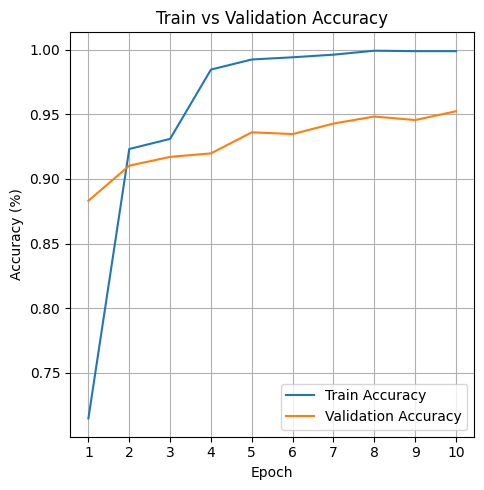

In [21]:
from training import backward_pass
from training import evaluate
%reload_ext autoreload
%autoreload 2

from plotting import make_train_val_plot

criterion = nn.CrossEntropyLoss()

model = classifier.model

max_num_epochs = 10
num_epochs = max_num_epochs
model.train()

print("Training with params:")
print(json.dumps(asdict(training_params), indent=4, sort_keys=True))

classifier.start_training()

progress_bar = tqdm(range(1, max_num_epochs + 1), desc="Epoch")
for epoch in progress_bar:
    running_loss = 0.0
    correct = 0
    total = 0

    classifier.maybe_unfreeze(epoch)

    for inputs, labels in tqdm(train_loader, desc="Batch"):
        inputs, labels = inputs.to(classifier.device), labels.to(classifier.device)
        classifier.optimizer.zero_grad()
        outputs, loss = backward_pass(classifier, inputs, labels, criterion)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = correct / total

    should_record_metrics = classifier.should_record_metrics()
    if should_record_metrics:
        val_acc = evaluate(model, val_loader, classifier.device)
        val_acc_str = f", Val Acc: {100 * val_acc:.2f}%"
    else:
        val_acc = None
        val_acc_str = ""
    classifier.epoch_losses.append(running_loss / len(train_loader))
    classifier.training_accuracies.append(train_acc)
    if should_record_metrics:
        classifier.validation_accuracies.append(val_acc)

    tqdm.write(
        f"Epoch [{epoch}/{max_num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Acc: {100 * train_acc:.2f}%{val_acc_str}")

    if classifier.should_stop_training_early():
        num_epochs = epoch
        break

epochs = range(1, num_epochs + 1)
make_train_val_plot(epochs, classifier.training_accuracies, classifier.validation_accuracies)


# Test model

Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 92.31%
Number of misclassified samples: 282


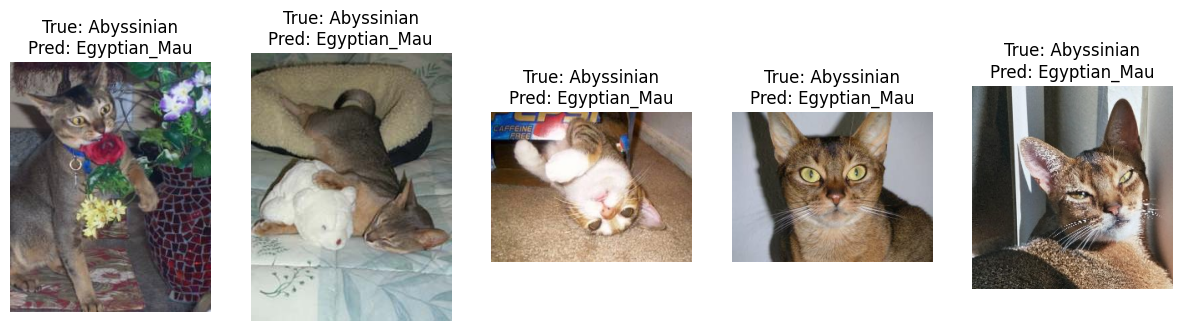

Copied 282 misclassified images to ./misclassified


In [22]:
from matplotlib import pyplot as plt
import shutil

# Directory for saving misclassified images
misclassified_dir = "./misclassified"

if os.path.exists(misclassified_dir):
    shutil.rmtree(misclassified_dir)
os.makedirs(misclassified_dir, exist_ok=True)


# Evaluate and collect misclassified samples
def evaluate_and_collect_misclassified(model, loader, device, dataset):
    model.eval()
    correct = 0
    total = 0
    misclassified = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(loader, desc="Evaluating")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(inputs.size(0)):
                if predicted[i] != labels[i]:
                    img_idx = idx * loader.batch_size + i
                    img_path = dataset._images[img_idx]
                    true_label = dataset._bin_labels[img_idx]
                    misclassified.append((img_path, true_label, predicted[i].item()))

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total, misclassified


final_test_acc, misclassified_samples = evaluate_and_collect_misclassified(model, test_loader, classifier.device, test_dataset)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples)}")


def to_text(label: int):
    breed_names = [
        "Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair", "Egyptian_Mau",
        "Maine_Coon", "Persian", "Ragdoll", "Russian_Blue", "Siamese", "Sphynx",
        "american_bulldog", "american_pit_bull_terrier", "basset_hound", "beagle",
        "boxer", "chihuahua", "english_cocker_spaniel", "english_setter", "german_shorthaired",
        "great_pyrenees", "havanese", "japanese_chin", "keeshond", "leonberger",
        "miniature_pinscher", "newfoundland", "pomeranian", "pug", "saint_bernard",
        "samoyed", "scottish_terrier", "shiba_inu", "staffordshire_bull_terrier", "wheaten_terrier",
        "yorkshire_terrier"
    ]
    return breed_names[label]


from PIL import Image

# Plot the first 5 misclassified images
num_to_plot = min(5, len(misclassified_samples))
plt.figure(figsize=(15, 5))

for i in range(num_to_plot):
    img_path, true_label, predicted_label = misclassified_samples[i]
    img = Image.open(img_path)
    plt.subplot(1, num_to_plot, i + 1)
    plt.imshow(img)
    plt.title(f"True: {to_text(true_label)}\nPred: {to_text(predicted_label)}")
    plt.axis('off')

plt.show()

for i, (img_path, true_label, predicted_label) in enumerate(misclassified_samples):
    filename = os.path.basename(img_path)
    new_filename = f"{i:04d}_true{true_label}_pred{predicted_label}_{filename}"
    shutil.copy(img_path, os.path.join(misclassified_dir, new_filename))

print(f"Copied {len(misclassified_samples)} misclassified images to {misclassified_dir}")
